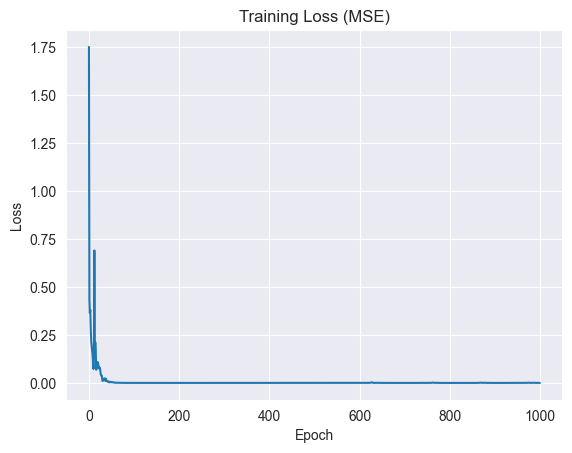

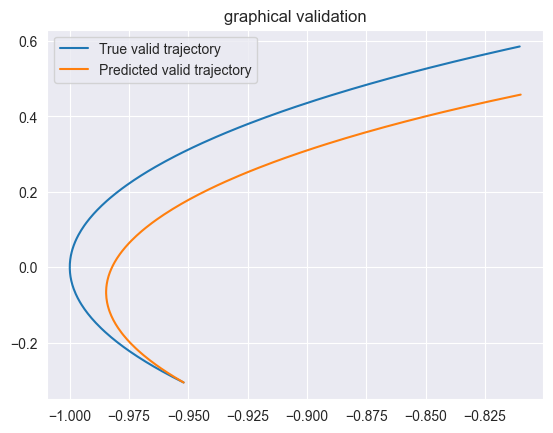

모델 0 valid r^2 : 0.9991984405466571


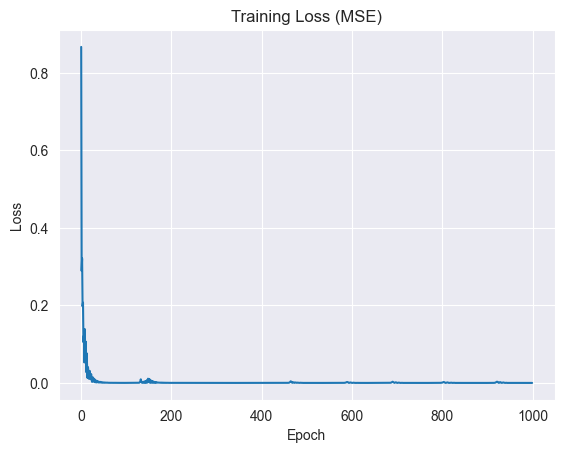

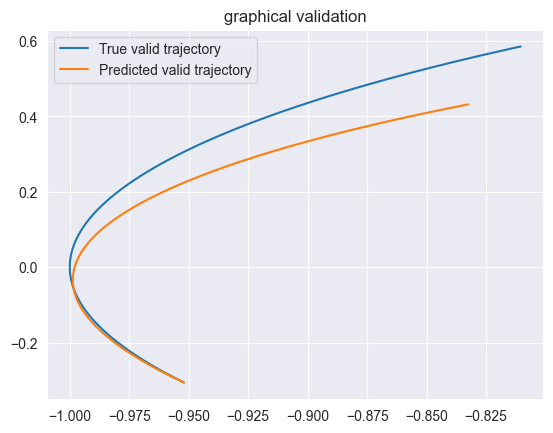

모델 1 valid r^2 : 0.9985003191562133


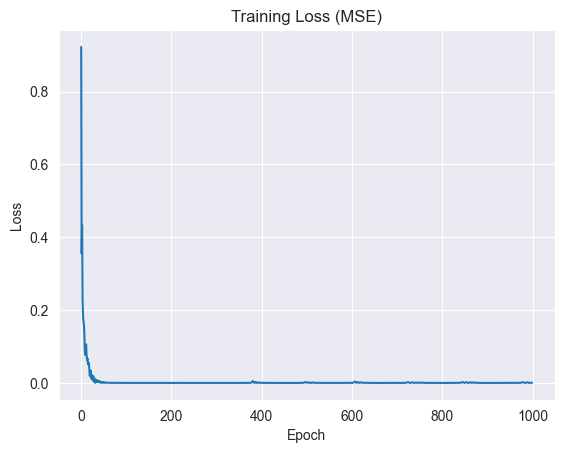

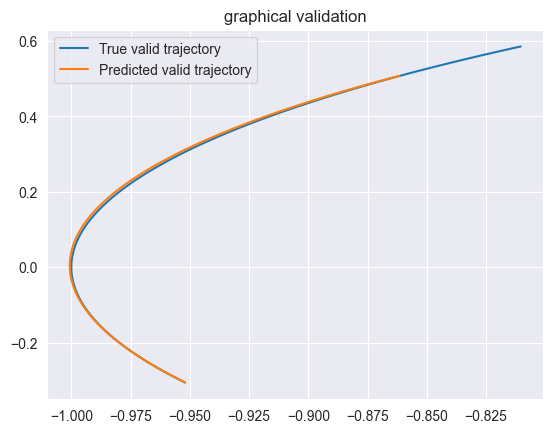

모델 2 valid r^2 : 0.9992525466759862


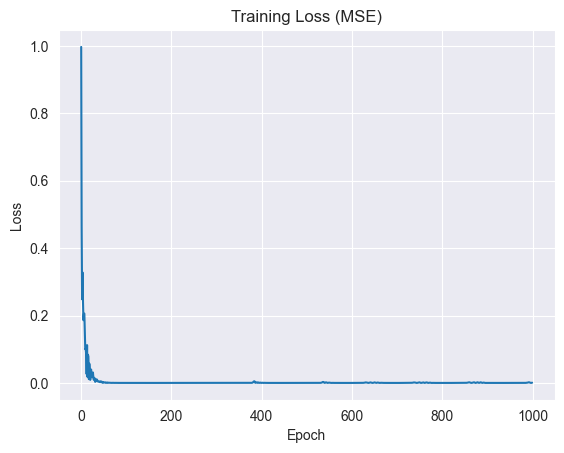

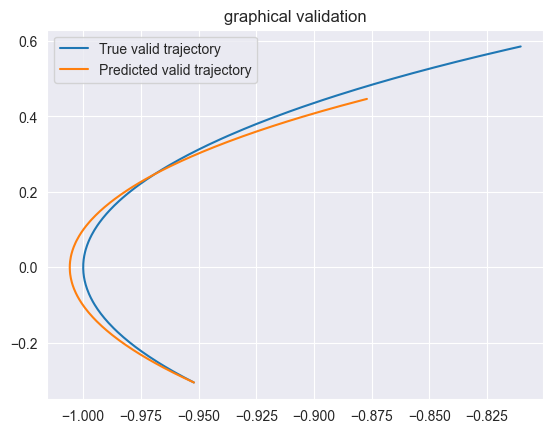

모델 3 valid r^2 : 0.9981093150186966


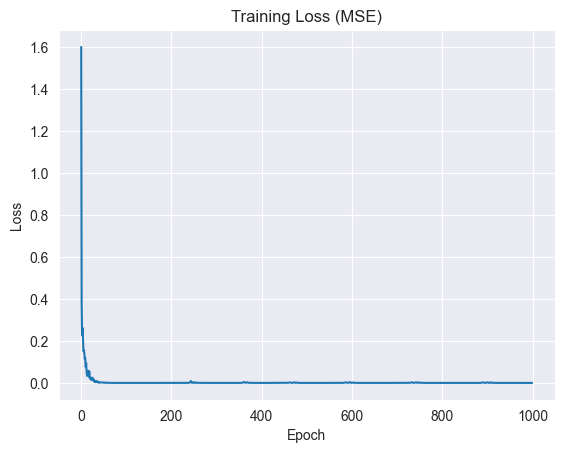

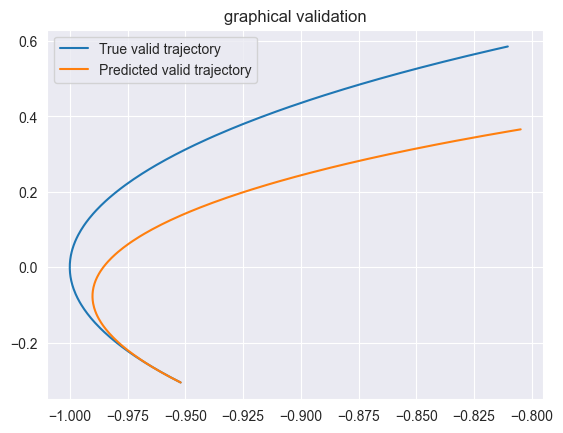

모델 4 valid r^2 : 0.9970147527346293
가장 우수한 모델: 2, valid r^2 :0.9992525466759862


In [4]:
import copy

from pyDOE import lhs
import torch
from torch import nn
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error
from prettytable import PrettyTable


# Latin Hypercube Design (LHD)를 이용해 샘플 생성
n_samples = 1500
lhd_samples = lhs(2, samples=n_samples)

# LHD샘플로 원형운동 데이터 생성
# float64 타입 이슈
t_lhd = torch.tensor(np.sort(lhd_samples[:, 0]) * 2 * np.pi, dtype=torch.float32) # dtype added here (이슈 해결 위해), t 정렬
x_lhd = torch.cat((torch.sin(t_lhd).reshape(-1, 1), torch.cos(t_lhd).reshape(-1, 1)), dim=1)


# 데이터를 훈련, 검증, 테스트 세트로 나눔
train_size = int(0.7 * len(x_lhd))
val_size = int(0.15 * len(x_lhd))
test_size = len(x_lhd) - train_size - val_size

# 훈련 세트
x_train = x_lhd[:train_size]
t_train = t_lhd[:train_size]

# validation 세트
x_val = x_lhd[train_size:train_size + val_size]
t_val = t_lhd[train_size:train_size + val_size]

# 테스트 세트
x_test = x_lhd[train_size + val_size:]
t_test = t_lhd[train_size + val_size:]

r_squared_val=[]
r_squared_check=0

best_func = None

for model in range(5):
    
    r_squared_index = model
    
    #initialize
    # Neural network를 사용하여 ODEF 클래스를 정의
    class ODEF(nn.Module):
        def forward(self, t, x):
            return self.net(x)

        def __init__(self, in_dim, hidden_dim, out_dim):
            super(ODEF, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, out_dim)
            )

    # Neural ODE definition
    func = ODEF(2, 50, 2)  # 입력 차원, 은닉 뉴런 수, 출력 차원
    optimizer = torch.optim.Adam(func.parameters(), lr=0.01)  #옵티마이저 설정
    
    losses = [] 
    for epoch in range(1000):
        optimizer.zero_grad()
        x_pred_train = odeint(func, x_train[0], t_train).squeeze()
        loss = ((x_pred_train - x_train) ** 2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
   
    x_pred_val = odeint(func, x_val[0], t_val).squeeze()
    
    #losses check
    plt.plot(losses)
    plt.title('Training Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
   
    #graphical validation
    plt.plot(x_val[:, 0].detach().numpy(), x_val[:, 1].detach().numpy(), label='True valid trajectory')
    plt.plot(x_pred_val[:, 0].detach().numpy(), x_pred_val[:, 1].detach().numpy(), label='Predicted valid trajectory')
    plt.legend()
    plt.title('graphical validation')
    plt.show()
    
    #numerical validation
    slope, intercept, r_value, _, _ = linregress(x_val.flatten().detach().numpy(), x_pred_val.flatten().detach().numpy())

    r_squared_val.append(r_value**2)
    
    if r_squared_check<r_squared_val[r_squared_index]:
        r_squared_check = r_squared_val[r_squared_index]
        best_func = copy.deepcopy(func) #현재 모델을 복제하여 best_func에 저장
    
    print(f"모델 {model} valid r^2 : {r_squared_val[r_squared_index]}")
    
#가장 우수한 모델 선정
max_r_squared_model = r_squared_val.index(max(r_squared_val)) #index는 0부터 시작하므로

print(f"가장 우수한 모델: {max_r_squared_model}, valid r^2 :{max(r_squared_val)}")

func = best_func #복제해 둔 최우수 모델을 func에 저장
      

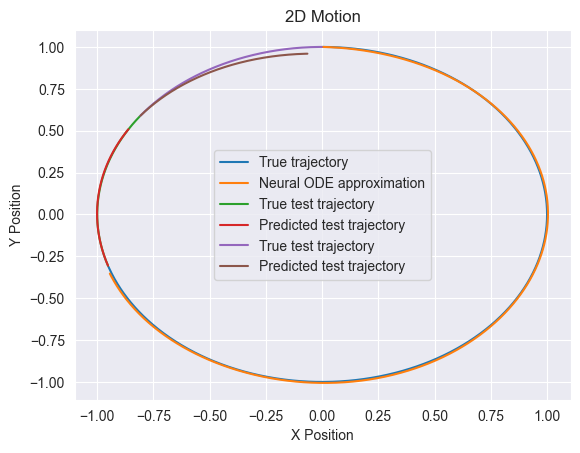

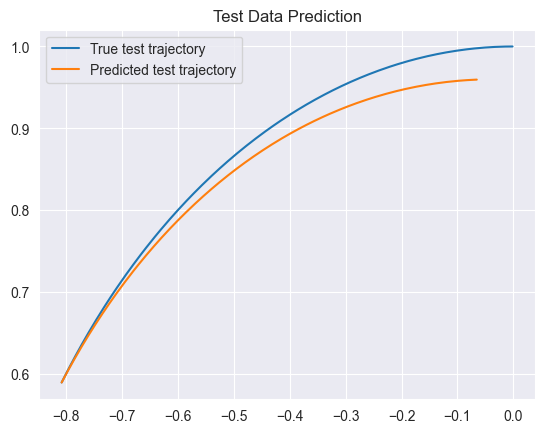

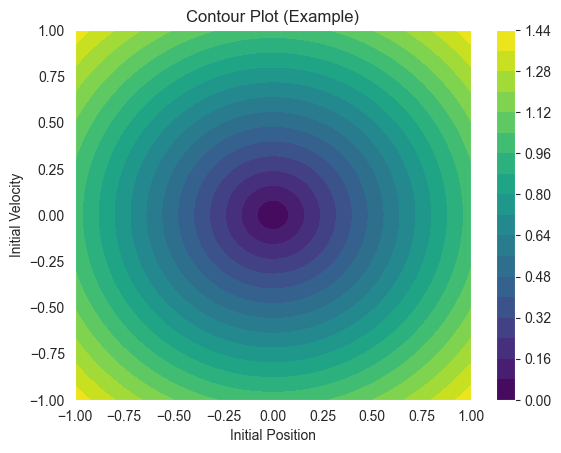

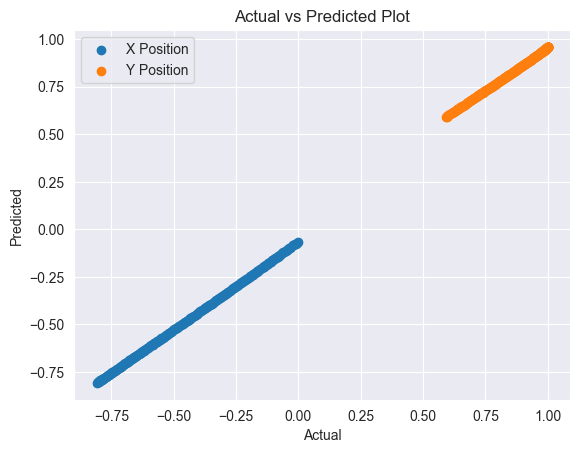

In [5]:
# Plotting the training loss
#plt.plot(losses)
#plt.title('Training Loss (MSE)')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.show()

# Plotting the true trajectory and the Neural ODE approximation
plt.plot(x_train[:, 0].detach().numpy(), x_train[:, 1].detach().numpy(), label='True trajectory')
x_pred = odeint(func, x_train[0], t_train)
plt.plot(x_pred[:, 0].detach().numpy(), x_pred[:, 1].detach().numpy(), label='Neural ODE approximation')

x_pred_val = odeint(func, x_val[0], t_val).squeeze()
plt.plot(x_val[:, 0].detach().numpy(), x_val[:, 1].detach().numpy(), label='True test trajectory')
plt.plot(x_pred_val[:, 0].detach().numpy(), x_pred_val[:, 1].detach().numpy(), label='Predicted test trajectory')

x_pred_test = odeint(func, x_test[0], t_test).squeeze()
plt.plot(x_test[:, 0].detach().numpy(), x_test[:, 1].detach().numpy(), label='True test trajectory')
plt.plot(x_pred_test[:, 0].detach().numpy(), x_pred_test[:, 1].detach().numpy(), label='Predicted test trajectory')

plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Motion')
plt.show()

# Testing the model
x_pred_test = odeint(func, x_test[0], t_test).squeeze()
plt.plot(x_test[:, 0].detach().numpy(), x_test[:, 1].detach().numpy(), label='True test trajectory')
plt.plot(x_pred_test[:, 0].detach().numpy(), x_pred_test[:, 1].detach().numpy(), label='Predicted test trajectory')
plt.legend()
plt.title('Test Data Prediction')
plt.show()

# Contour plot for specific time and acceleration
# This part can be customized based on the specific modeling of the system
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
Z = np.sqrt(X**2 + Y**2)  # Example: distance from the origin
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('Contour Plot (Example)')
plt.xlabel('Initial Position')
plt.ylabel('Initial Velocity')
plt.show()

# Testing the model
x_pred_test = odeint(func, x_test[0], t_lhd[train_size + val_size:]).squeeze()

# Graphical Validation
plt.scatter(x_test[:, 0].detach().numpy(), x_pred_test[:, 0].detach().numpy(), label='X Position')
plt.scatter(x_test[:, 1].detach().numpy(), x_pred_test[:, 1].detach().numpy(), label='Y Position')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Actual vs Predicted Plot')
plt.show()


In [6]:

# Numerical Validation
slope, intercept, r_value, _, _ = linregress(x_test.flatten().detach().numpy(), x_pred_test.flatten().detach().numpy())

r_squared = r_value**2
mean_abs_rel_residual = mean_absolute_error(x_test.detach().numpy(), x_pred_test.detach().numpy()) / (x_test.abs().mean())
# Calculate max absolute relative residual for multioutput
max_abs_rel_residual = max(np.max(np.abs(x_test.detach().numpy() - x_pred_test.detach().numpy()), axis=0) / x_test.abs().max())



# Summarize the results
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Squared correlation coefficient (r^2)", r_squared])
table.add_row(["Mean absolute relative residual", mean_abs_rel_residual])
table.add_row(["Maximum of absolute relative residuals", max_abs_rel_residual])

print(table)



+----------------------------------------+-------------------+
|                 Metric                 |       Value       |
+----------------------------------------+-------------------+
| Squared correlation coefficient (r^2)  | 0.999414722230813 |
|    Mean absolute relative residual     |   tensor(0.0489)  |
| Maximum of absolute relative residuals |   tensor(0.0640)  |
+----------------------------------------+-------------------+


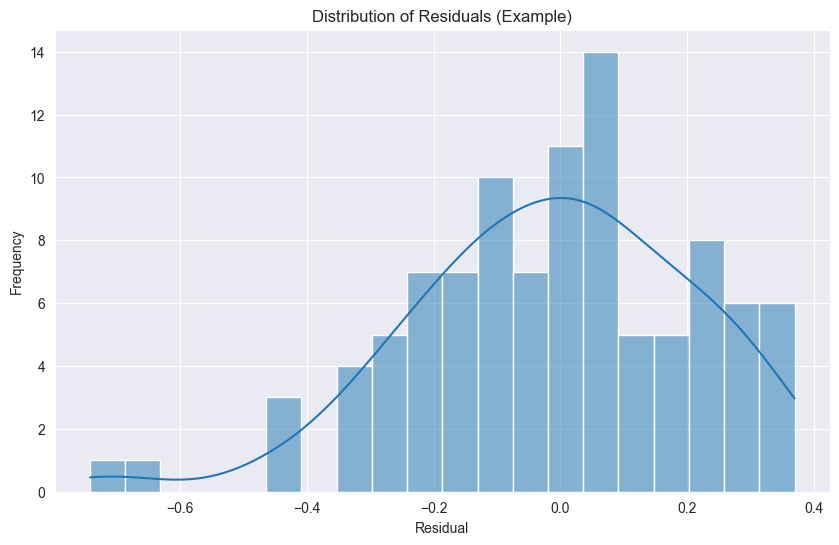

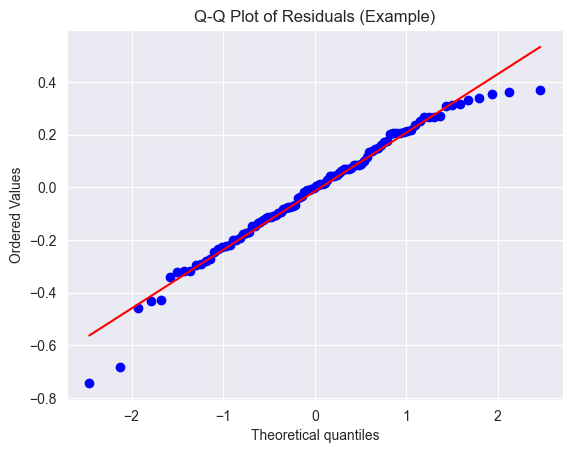

Normality test p-value (Example): 0.030896833018160836


In [16]:
from scipy.stats import probplot, normaltest
import seaborn as sns

# Generating example data for demonstration
np.random.seed(42)
x_values = np.linspace(0, 2 * np.pi, 100)
y_actual = np.sin(x_values) + 0.1 * np.random.normal(size=x_values.shape)
y_predicted = np.sin(x_values) + 0.2 * np.random.normal(size=x_values.shape)

# Calculating residuals for the example data
residuals_example = y_actual - y_predicted

# Plotting residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_example, kde=True, bins=20)
plt.title('Distribution of Residuals (Example)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of residuals
probplot(residuals_example, plot=plt)
plt.title('Q-Q Plot of Residuals (Example)')
plt.show()

# Normality test
k2, p_value_example = normaltest(residuals_example)
print("Normality test p-value (Example):", p_value_example)


C:\Users\admin\AppData\Local\Temp\ipykernel_8652\893590710.py:17: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_true, levels=20, colors='r', linestyles='dashed', label='True motion')
C:\Users\admin\AppData\Local\Temp\ipykernel_8652\893590710.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z_pred, levels=20, colors='b', linestyles='solid', label='Predicted motion')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


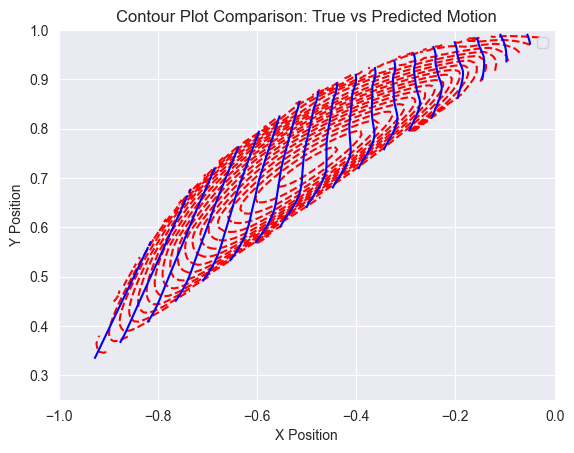

In [17]:
from scipy.interpolate import griddata

# Create a meshgrid for the contour plot
num_points = 100
X, Y = np.meshgrid(np.linspace(-1, 0, num_points), np.linspace(0.25, 1, num_points))

# Create points and values for interpolation
points = x_test.detach().numpy()
values_true = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
values_pred = np.sqrt(x_pred_test[:, 0].detach().numpy()**2 + x_pred_test[:, 1].detach().numpy()**2)

# Interpolate the values for the contour plot
Z_true = griddata(points, values_true, (X, Y), method='cubic')
Z_pred = griddata(points, values_pred, (X, Y), method='cubic')

# Plot the true contour
plt.contour(X, Y, Z_true, levels=20, colors='r', linestyles='dashed', label='True motion')

# Plot the predicted contour
plt.contour(X, Y, Z_pred, levels=20, colors='b', linestyles='solid', label='Predicted motion')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Contour Plot Comparison: True vs Predicted Motion')
plt.legend()
plt.show()



In [18]:
print("X range in training:", x_train[:, 0].min().item(), "to", x_train[:, 0].max().item())
print("Y range in training:", x_train[:, 1].min().item(), "to", x_train[:, 1].max().item())

print("X range in prediction:", x_pred_test[:, 0].min().item(), "to", x_pred_test[:, 0].max().item())
print("Y range in prediction:", x_pred_test[:, 1].min().item(), "to", x_pred_test[:, 1].max().item())


X range in training: -0.999996542930603 to 1.0
Y range in training: -0.9999999403953552 to 0.9999997019767761
X range in prediction: -0.9505892992019653 to -0.05371150001883507
Y range in prediction: 0.3104511797428131 to 0.9435471892356873
